## Advanced Lane Finding Project

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.

---
## First, I'll compute the camera calibration using chessboard images

In [1]:
import numpy as np
import cv2
import glob
import utils
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
images = glob.glob('./camera_cal/calibration*.jpg')
mtx, dist = utils.calibrate_camera(images)

## Calibrate the camera and undistort the image

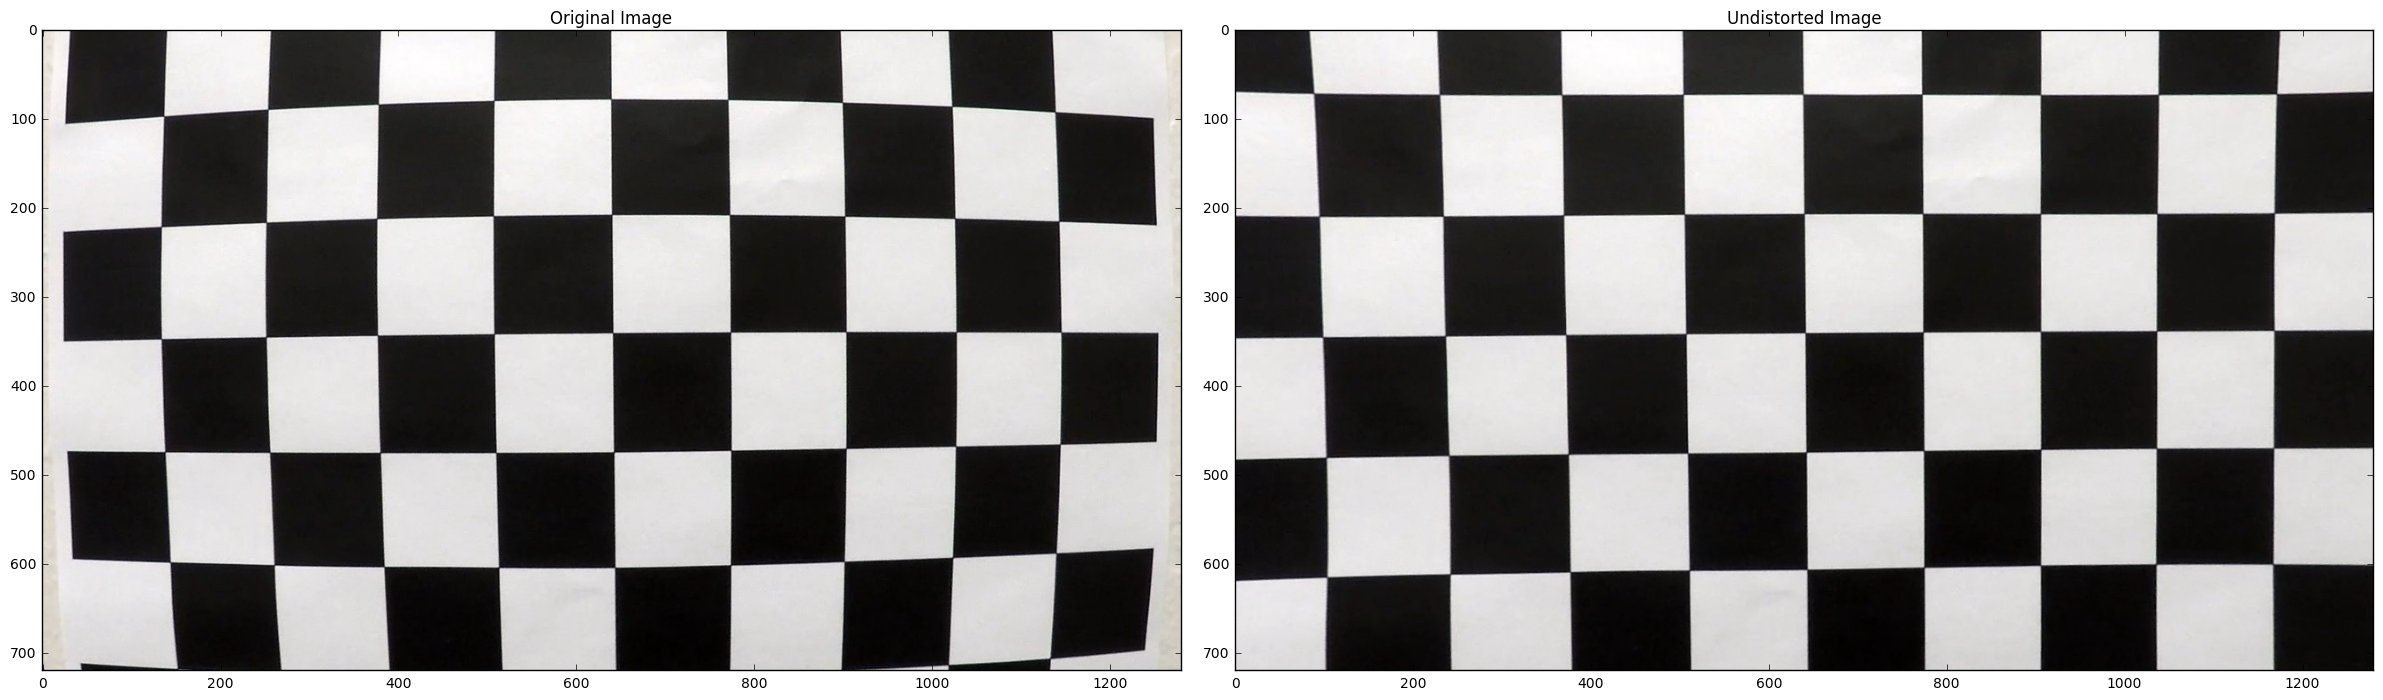

In [3]:
#generate the image correction matrix
img = utils.load_image('./camera_cal/calibration1.jpg')

dst = utils.undistort(img, mtx, dist)

f, (axis1, axis2) = plt.subplots(1, 2, figsize=(24,9))
f.tight_layout()
axis1.imshow(img)
axis1.set_title('Original Image')
axis2.imshow(dst)
axis2.set_title('Undistorted Image')

In [191]:
def perspective_transform(img, src, dst):
    M = cv2.getPerspectiveTransform(src, dst)
    return cv2.warpPerspective(img, M, (img.shape[1],img.shape[0]), flags=cv2.INTER_LINEAR)

In [198]:
def get_transformation_source(h,w, left=0.445, right=0.555, top=0.65, bottom=1):
    top_left = [w*left, h*top,]
    top_right = [w*right, h*top]
    bottom_left = [w*0.16, h*bottom]
    bottom_right = [w*0.86, h*bottom]
    return np.array([top_left,bottom_left, bottom_right, top_right], np.float32)

def get_transformation_destination(h,w):
    top_left = [w*0.25, 0]
    top_right = [w*0.75, 0]
    bottom_left = [w*0.25, h]
    bottom_right = [w*0.75, h]
    return np.array([top_left,bottom_left, bottom_right, top_right], np.float32)

def weighted_img(img, initial_img, α=0.8, β=1., λ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + λ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, λ)

In [199]:
def draw_region_of_interest(img, region, color=[255,0,0]):
    left_top = tuple(region[0])
    left_bottom = tuple(region[1])
    right_bottom = tuple(region[2])
    right_top = tuple(region[3])

    cv2.line(img, left_bottom, left_top, color,2)
    cv2.line(img, left_top, right_top, color, 2)
    cv2.line(img, right_top, right_bottom, color, 2)
    cv2.line(img, right_bottom, left_bottom, color, 2)


In [223]:
def convert_to_birds_eye_view(img):
    h, w = img.shape[:2]
    
    src = get_transformation_source(h, w)
    dest = get_transformation_destination(h, w)
    
    #src = np.float32([[585,460],[203,720],[1127,720],[695,460]])
    #dst = np.float32([[320,0],[320,720],[960,720],[960,0]])
    img = perspective_transform(img, src, dest)
    
    return img, src, dest

Test the perespective transformation on a straight road segment

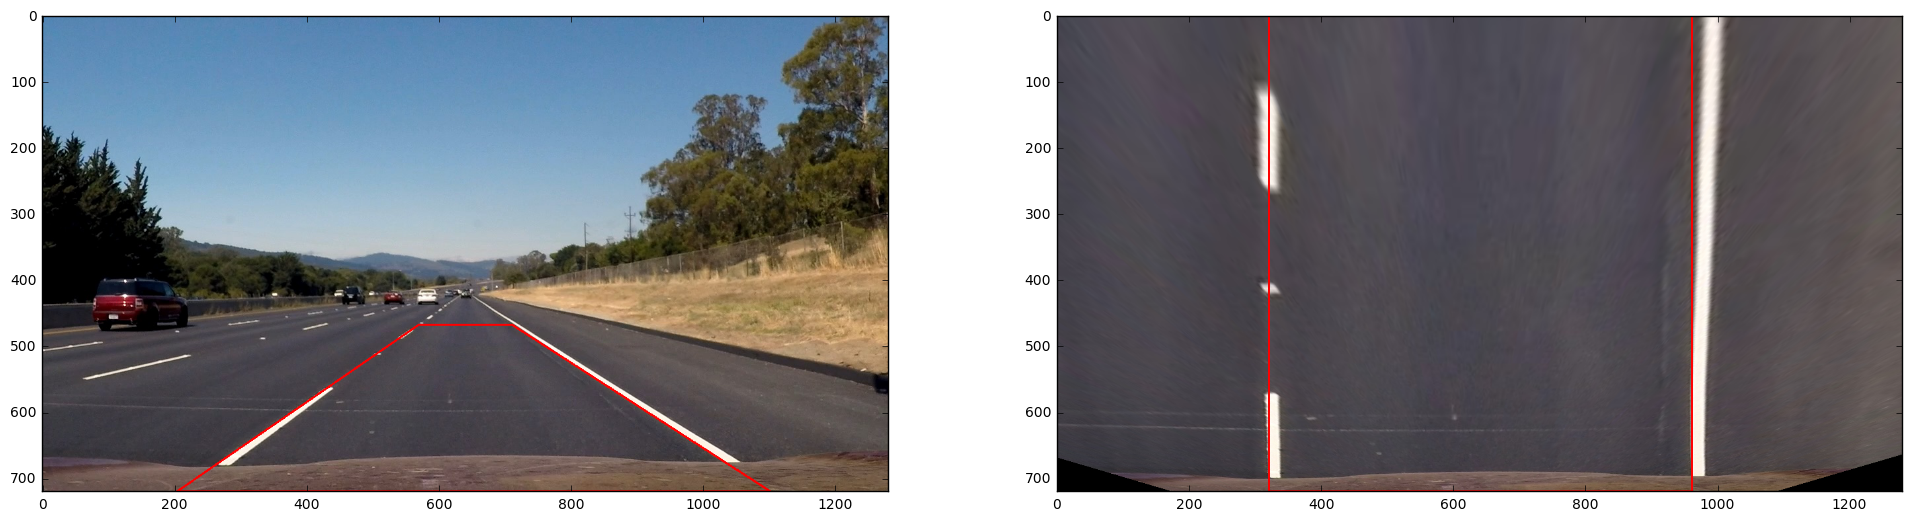

In [224]:
img = utils.load_image('./test_images/straight_lines2.jpg')

img_top, src, dest = convert_to_birds_eye_view(img)
draw_region_of_interest(img, src)
draw_region_of_interest(img_top, dest)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
ax1.imshow(img)
ax2.imshow(img_top)

In [226]:
def pipeline(img, mtx, dist, c_thresh=(170, 255), x_thresh=(20, 100)):
    img = utils.undistort(img, mtx, dist)
    
    # Threshold x gradient
    x_binary = utils.abs_sobel_thresh(img, thresh=x_thresh)
    
    # Threshold color channel
    color_binary = utils.color_thresh(img, s_thresh=c_thresh)
    
    #mag_binary = utils.mag_thresh(img, sobel_kernel=ksize, thresh=(100, 255))
    #dir_binary = dir_threshold(img, sobel_kernel=15, thresh=(0, np.pi/2))
    
    combined_binary = np.zeros_like(x_binary)
    combined_binary[(color_binary == 1) | (x_binary == 1)] = 1
    
    #convert to birds eye view
    res, src, dst = convert_to_birds_eye_view(combined_binary)
        
    return res

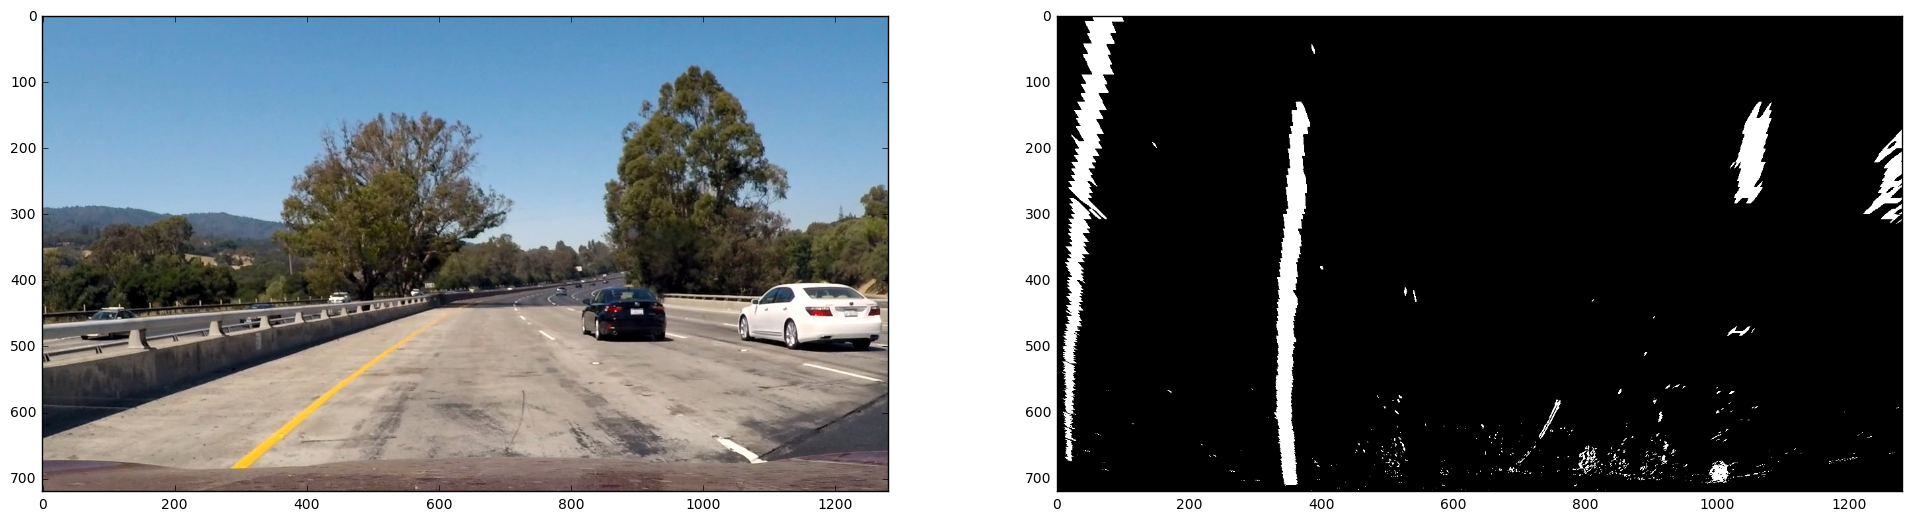

In [230]:
img = utils.load_image('./test_images/test1.jpg')
#img = cv2.flip(img, 1)

res = pipeline(img, mtx, dist, c_thresh=(170, 255), x_thresh=(20, 100))

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
ax1.imshow(img)
ax2.imshow(res, cmap='gray')

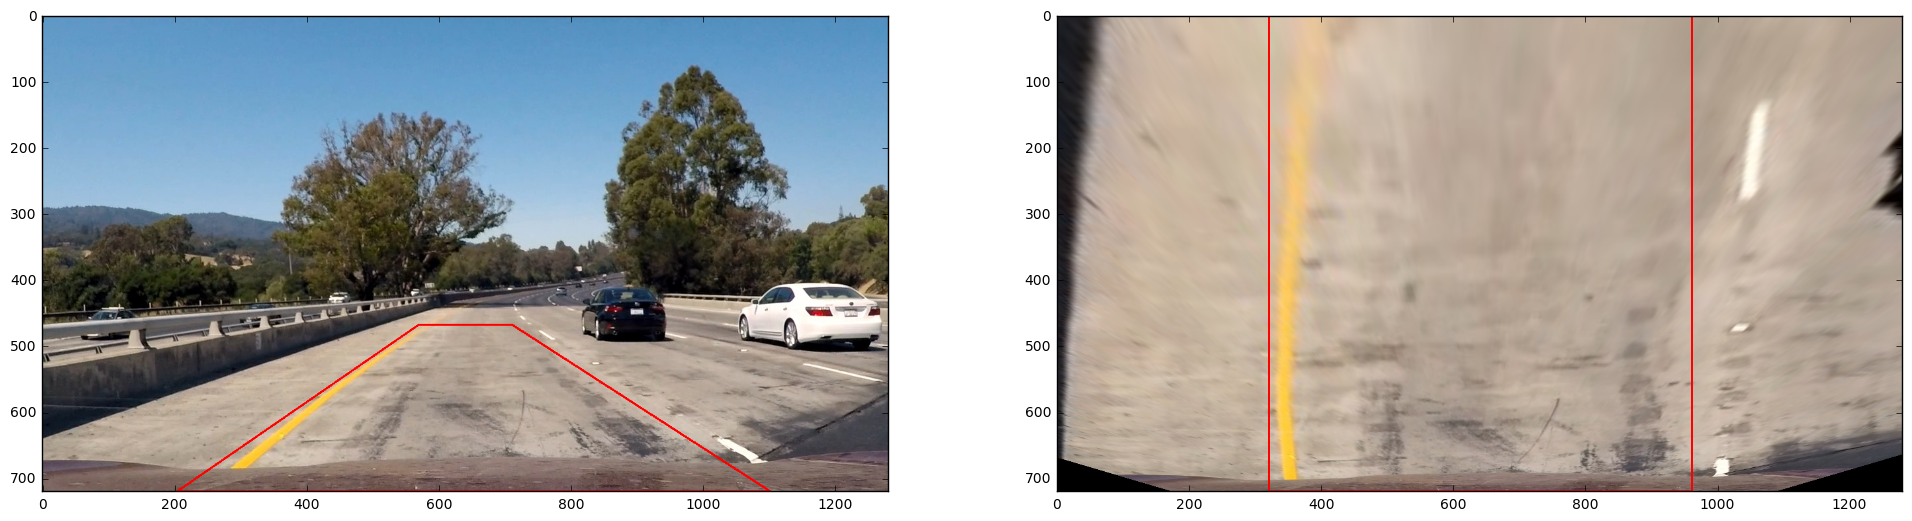

In [231]:
img_top, src, dest = convert_to_birds_eye_view(img)
draw_region_of_interest(img, src)
draw_region_of_interest(img_top, dest)

f,(ax1,ax2) = plt.subplots(1,2,figsize=(24,9))
ax1.imshow(img)
ax2.imshow(img_top)